## Imports

In [32]:
using Pkg
Pkg.activate("SCC", shared=true)

import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using ProgressMeter
using LoggingExtras
using Revise
using Dates
using YAXArrays

import JSON3

import LsqFit as LF


  Activating project at `~/.julia/environments/SCC`


In [8]:
import SuperconductingCavities as SC

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /Users/gavinrockwood/.julia/packages/YAXArrayBase/M48vP/ext/NetCDFExt.jl:110


## Logger Setups

In [9]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model

In [15]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3SmallRes/Mode3SmallRes.json");

# Checking Collapse and Dephasing Ops

Image of the code used to construct the ops. Found in SuperconductingCavities/src/Circuits/Ciruit_Types/Transmon_Resonators/Constructor.jl

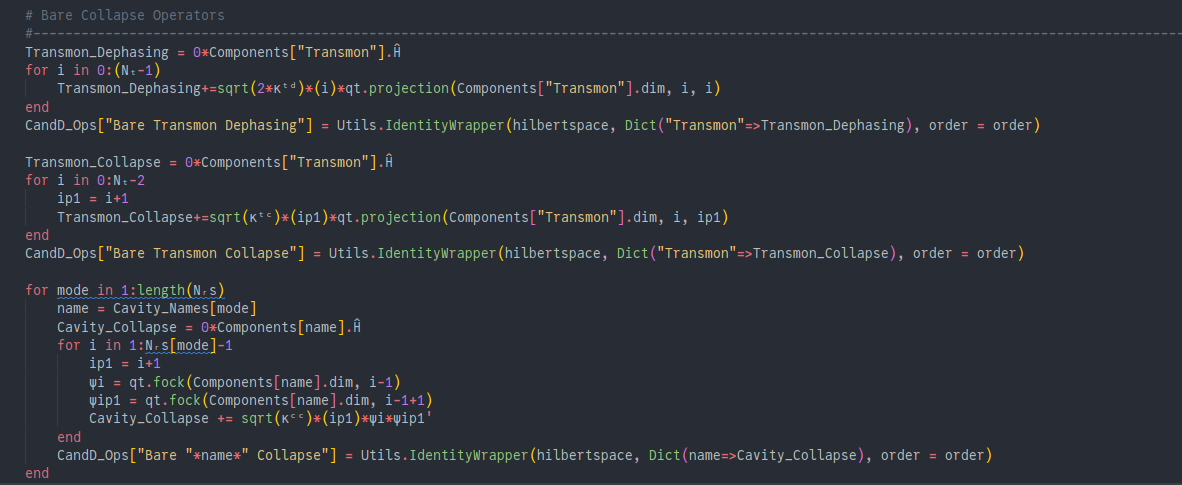

## ge dephasing

In [45]:
CandD_Check_ge = SC.Utils.LoadRunResults("Data/CheckingCollapseAndDephasing_Thu-Jan-9-25.13.24/ge.nc", cube_order = ["ge"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, …
  "states" => Any[Quantum Object:   type=Operator   dims=[10, 2]   size=(20, 20…

In [49]:
Proj_Ops_Temp_ge = SC.Utils.Get_Projection_Ops(Dict{Any, Any}((0,0) => Mode3.dressed_states[(0,0)], (1,0) => Mode3.dressed_states[(1,0)]))

EVs_ge = SC.Utils.Get_EVs(CandD_Check_ge["states"], Proj_Ops_Temp_ge)

Dict{Any, Any} with 2 entries:
  (0, 0) => ComplexF64[0.5+3.69812e-38im, 0.500891-2.37677e-38im, 0.501781-6.39…
  (1, 0) => ComplexF64[0.5-1.21622e-35im, 0.499108+2.89362e-37im, 0.498217-6.33…

In [50]:
g0 = Mode3.dressed_states[(0,0)]
e0 = Mode3.dressed_states[(1,0)]

e_diag = []
ge_off_diag = []

for i in 1:length(CandD_Check_ge["states"])
    ρ = CandD_Check_ge["states"][i]
    push!(e_diag, e0'*ρ*e0)
    push!(ge_off_diag, g0'*ρ*e0)
end

In [51]:
to_fit(t, p) = 0.5*ℯ.^(-t.*p)

y = abs.(e_diag)
x = CandD_Check_ge["times"]

kappa1_ge_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1]


y = abs.(ge_off_diag)
x = CandD_Check_ge["times"]

kappa2_ge_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1];

In [52]:
println("ge kappa1_Fit: $kappa1_ge_Fit")
println("ge kappa2_Fit: $kappa2_ge_Fit")

kappaϕ_ge_Fit = (kappa2_ge_Fit-kappa1_ge_Fit/2)
println("ge kappaϕ_Fit: $kappaϕ_ge_Fit")



ge kappa1_Fit: 1.7862696690110556e-5
ge kappa2_Fit: 2.1223698962333108e-5
ge kappaϕ_Fit: 1.229235061727783e-5


In [53]:
println("Used ge kappa1: $(Mode3.params["kappa_tc"])")

kappa2 = Mode3.params["kappa_tc"]/2 + Mode3.params["kappa_td"]
println("Used ge kappa2: $(kappa2)")

println("Used ge kappaϕ: $(Mode3.params["kappa_td"])")

Used ge kappa1: 1.785714285714286e-5
Used ge kappa2: 2.1276595744680852e-5
Used ge kappaϕ: 1.2348024316109425e-5


In [62]:
kappa1_ge_exp = 1/56/1000
kappa2_ge_exp = 1/47/1000
println("Experiment ge kappa1: $(kappa1_ge_exp)")
println("Experiment ge kappa2: $(kappa2_ge_exp)")

kappaϕ_ge_exp = 1/47/1000 - 1/56/1000/2
println("Experiment ge kappaϕ: $kappaϕ_ge_exp")

Experiment ge kappa1: 1.7857142857142855e-5
Experiment ge kappa2: 2.1276595744680852e-5
Experiment ge kappaϕ: 1.2348024316109425e-5


In [57]:
to_save_e = Dict{Any, Any}("ge" => real.(ge_off_diag), "ee" => real.(e_diag), "time" => CandD_Check_ge["times"])

Dict{Any, Any} with 3 entries:
  "ee"   => [0.5, 0.499108, 0.498217, 0.497328, 0.49644, 0.495554, 0.494669, 0.…
  "time" => Any[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 90…
  "ge"   => [0.5, 0.498938, 0.497879, 0.496821, 0.495766, 0.494714, 0.493663, 0…

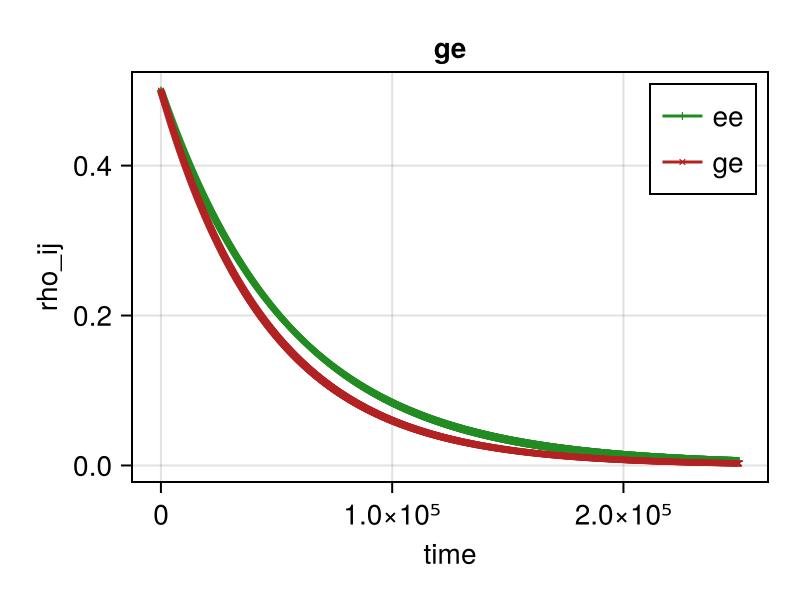

CairoMakie.Screen{IMAGE}


In [59]:
fig = cm.Figure(size = (400,300))
ax = cm.Axis(fig[1,1], xlabel = "time", ylabel = "rho_ij", title = "ge")

cm.scatterlines!(to_save_e["time"], to_save_e["ee"], color = "forestgreen", label = "ee", marker = '+')
cm.scatterlines!(to_save_e["time"], to_save_e["ge"], color = "firebrick", label = "ge", marker = '×')

cm.axislegend(ax)


display(fig)

## gf dephasing

In [13]:
CandD_Check_gf = SC.Utils.LoadRunResults("Data/CheckingCollapseAndDephasing_Thu-Jan-9-25.13.24/gf.nc", cube_order = ["gf"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, …
  "states" => Any[Quantum Object:   type=Operator   dims=[10, 2]   size=(20, 20…

In [48]:
Proj_Ops_Temp_gf = SC.Utils.Get_Projection_Ops(Dict{Any, Any}((0,0) => Mode3.dressed_states[(0,0)], (1,0) => Mode3.dressed_states[(1,0)], (2,0) => Mode3.dressed_states[(2,0)]))

EVs_gf = SC.Utils.Get_EVs(CandD_Check_gf["states"], Proj_Ops_Temp_gf)

Dict{Any, Any} with 3 entries:
  (0, 0) => ComplexF64[0.5+1.67433e-36im, 0.500001+1.39532e-36im, 0.500005-8.56…
  (2, 0) => ComplexF64[0.5+5.72046e-36im, 0.498218+8.12488e-36im, 0.496443+1.07…
  (1, 0) => ComplexF64[6.4441e-45+1.69611e-53im, 0.00178027+9.07579e-37im, 0.00…

[2025-01-09 13:29:52] Info: Making Plot


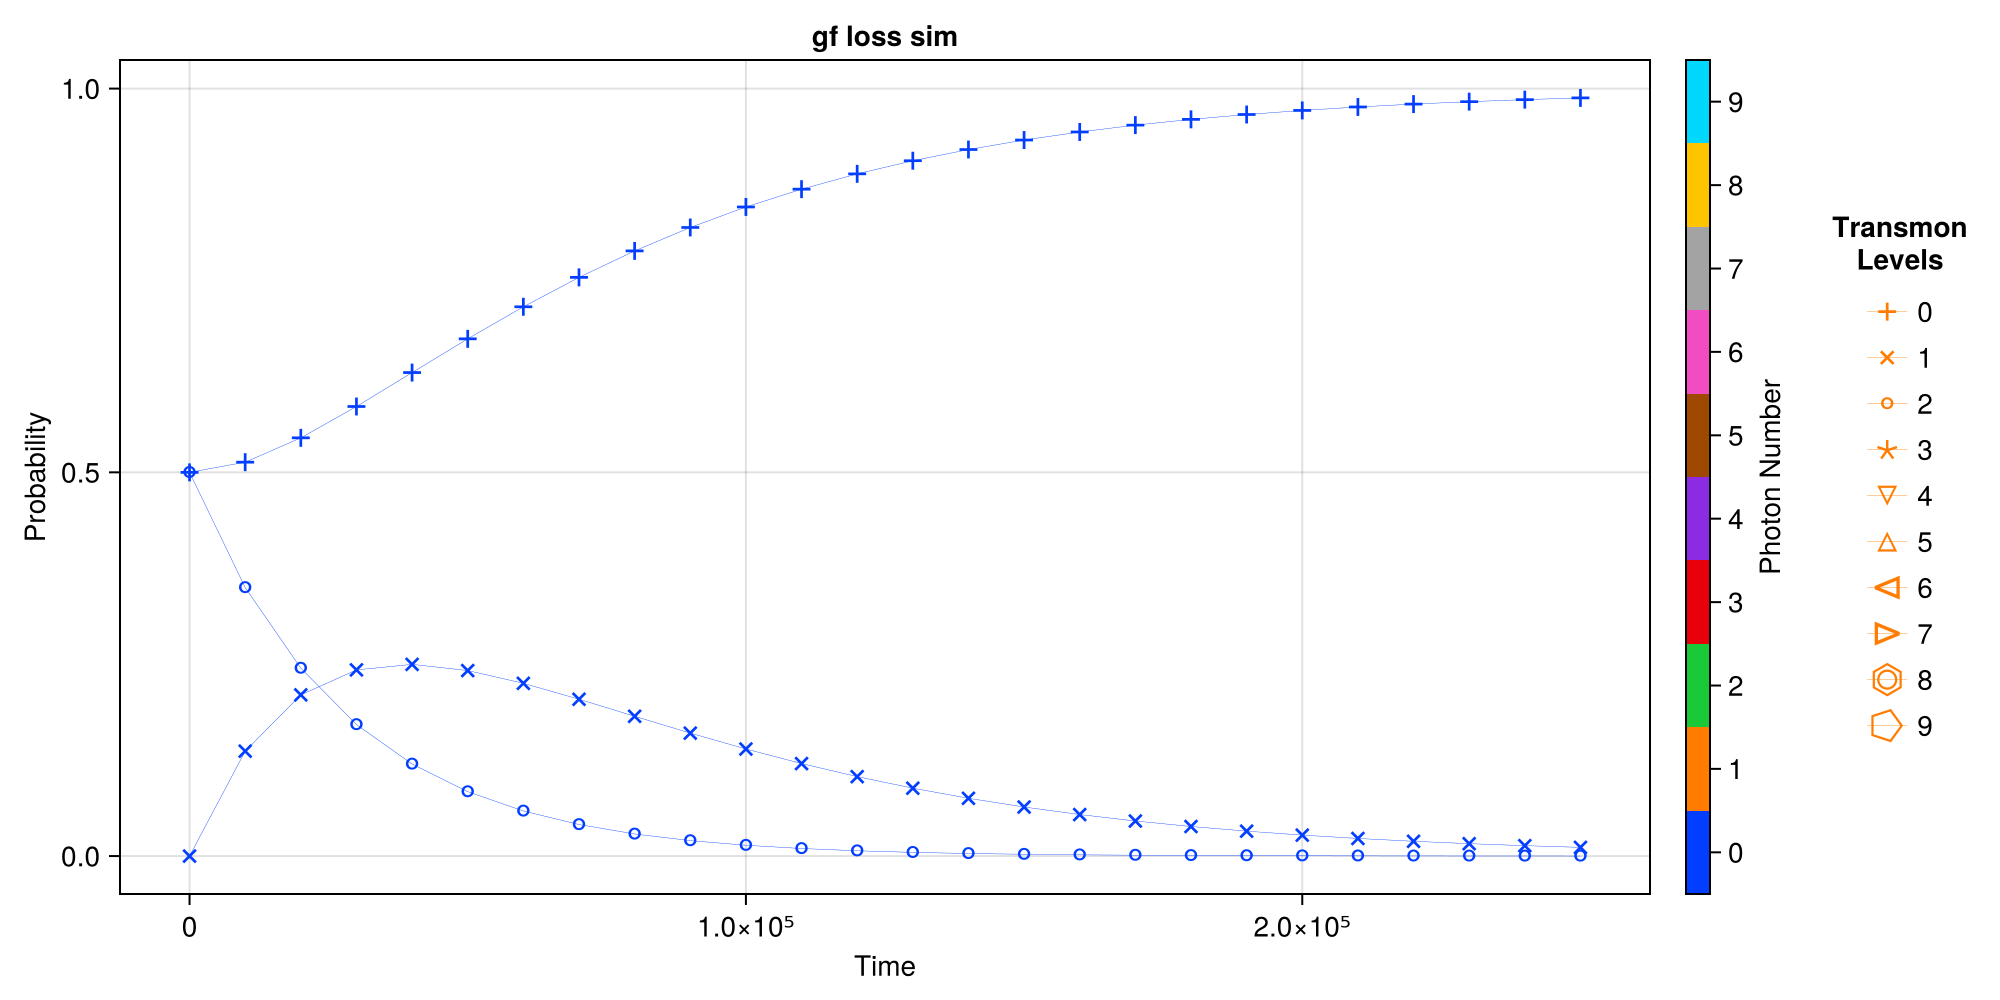

CairoMakie.Screen{IMAGE}


In [17]:
axis_kwargs = Dict{Any, Any}("title" => "gf loss sim")
SC.Dynamics.PlotSingleModeEvolution(Mode3, CandD_Check_gf["times"], EVs_gf, plot_every = 100, axis_kwargs = axis_kwargs)

In [18]:
g0 = Mode3.dressed_states[(0,0)]
f0 = Mode3.dressed_states[(2,0)]

f_diag = []
gf_off_diag = []

for i in 1:length(CandD_Check_gf["states"])
    ρ = CandD_Check_gf["states"][i]
    push!(f_diag, f0'*ρ*f0)
    push!(gf_off_diag, g0'*ρ*f0)
end

In [34]:
to_fit(t, p) = 0.5*ℯ.^(-t.*p)

y = abs.(f_diag)
x = CandD_Check_gf["times"]

kappa1_ef_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1]


y = abs.(gf_off_diag)
x = CandD_Check_gf["times"]

kappa2_gf_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1];

In [35]:
println("kappa1_Fit: $(kappa1_ef_Fit)")
println("kappa2_Fit: $kappa2_gf_Fit")

kappaϕ_gf_Fit = (kappa2_gf_Fit-kappa1_ef_Fit/2)
println("kappaϕ_Fit: $kappaϕ_gf_Fit")



kappa1_Fit: 3.569172355162765e-5
kappa2_Fit: 4.252565004752704e-5
kappaϕ_Fit: 2.4679788271713215e-5


In [36]:
kappa1_ef = Mode3.params["kappa_tc"]*(2)
println("Used kappa1: $(kappa1_ef)")

kappaϕ_gf = Mode3.params["kappa_td"]*2
kappa2_ef = (kappa1_ef)/2 + kappaϕ_gf
println("Used kappa2: $(kappa2_ef)")

println("Used kappaϕ: $(kappaϕ_gf)")

Used kappa1: 3.571428571428572e-5
Used kappa2: 4.2553191489361704e-5
Used kappaϕ: 2.469604863221885e-5


In [75]:
kappa1_ef_exp = kappa1_ge_exp*2#1/28/1000
kappa2_ef_exp = kappa2_ge_exp*2#1/36/1000
println("Experiment kappa1: $(kappa1_ef_exp)")
println("Experiment kappa2: $(kappa2_ef_exp)")

kappaϕ_exp = kappa2_ef_exp - kappa1_ef_exp/2 # this is the average T1 for f->e and e->g
println("Experiment kappaϕ: $kappaϕ_exp")

Experiment kappa1: 3.571428571428571e-5
Experiment kappa2: 4.2553191489361704e-5
Experiment kappaϕ: 2.469604863221885e-5


In [76]:
println(1/kappa2_ef_exp/1000)
println(1/kappa2_ef/1000)

23.5
23.5


In [41]:
to_save_f = Dict{Any, Any}("gf" => real.(gf_off_diag), "ff" => real.(f_diag), "time" => CandD_Check_gf["times"])

Dict{Any, Any} with 3 entries:
  "ff"   => [0.5, 0.498218, 0.496443, 0.494674, 0.492912, 0.491156, 0.489406, 0…
  "time" => Any[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 90…
  "gf"   => [0.5, 0.497878, 0.495765, 0.493661, 0.491566, 0.48948, 0.487403, 0.…

In [42]:
# open("decay_and_dephasing.json", "w") do f
#      JSON3.pretty(f, to_save)
# end

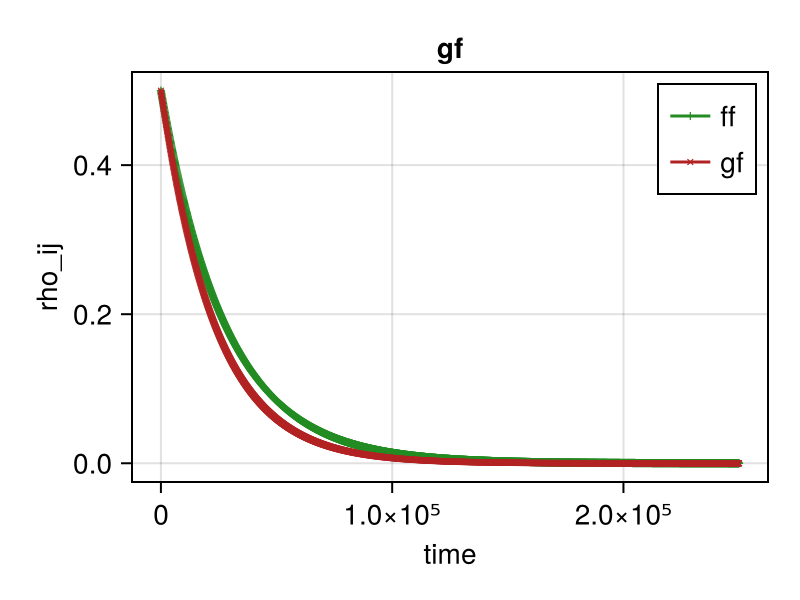

CairoMakie.Screen{IMAGE}


In [60]:
fig = cm.Figure(size = (400,300))
ax = cm.Axis(fig[1,1], xlabel = "time", ylabel = "rho_ij", title = "gf")

cm.scatterlines!(to_save_f["time"], to_save_f["ff"], color = "forestgreen", label = "ff", marker = '+')
cm.scatterlines!(to_save_f["time"], to_save_f["gf"], color = "firebrick", label = "gf", marker = '×')

cm.axislegend(ax)


display(fig)